# Modelo RANDOM FOREST

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, classification_report, ConfusionMatrixDisplay
import os

In [2]:
SEED = 42
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)
# c:\Users\Fran\Documents\2025-2_Seminario2\Uso-de-Inteligencia-Artificial-Geoespacial-para-Clasificar-Coberturas-Terrestres-en-Costa-Rica\dataset\PuntosMuestra_CR_2023.csv

## Limpieza

In [3]:
# Quitar valores de la CATEGORIA = 2
df_filtrado = df[df["CATEGORIA"] != 2]

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA", "lon", "lat", "year"])

## Dividir entrenamiento y prueba

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)


## Entrenamiento y medida de tiempo

In [5]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Define listas de valores para cada hiperparámetro de RF
# 200, None, 'sqrt', 5, 2, 'balanced'
n_estimators_list   = [100, 200]
max_depth_list      = [None]
max_features_list   = ["sqrt"]
min_split_list      = [2, 5]
min_leaf_list       = [1, 2]
class_weight_list   = ["balanced"]

mejor_cfg = None
mejor_f1  = -1
mejor_rf  = None
grich_n = 0

for (n_est, max_d, max_f, ms_s, ms_l, cw) in itertools.product(
    n_estimators_list, max_depth_list, max_features_list, min_split_list, min_leaf_list, class_weight_list
):
    grich_n = grich_n + 1
    print(f"RF Grich {grich_n}: ne={n_est}, md={max_d}, mf={max_f}, mss={ms_s}, msl={ms_l}, cw={cw} ")

    rf = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=max_d,
        max_features=max_f,
        min_samples_split=ms_s,
        min_samples_leaf=ms_l,
        class_weight=cw,
        random_state=42,
        n_jobs=-1
    )

    # Entrenar y medir tiempo
    t0_fit = time.perf_counter()
    rf.fit(X_train, y_train)
    fit_s = time.perf_counter() - t0_fit

    # Predecir y medir tiempo
    t0_pred = time.perf_counter()
    y_pred = rf.predict(X_test)
    pred_s = time.perf_counter() - t0_pred
    ms_per_sample = (pred_s / len(y_test)) * 1000

    # Métricas rápidas
    oa  = accuracy_score(y_test, y_pred)
    prec, rec, f1m, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
    cm  = confusion_matrix(y_test, y_pred)
    cm_row_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_row_percentage = np.nan_to_num(cm_row_percentage)  # handle division by zero

    print(f"⏱ Test: {pred_s:.3f}s  ({fit_s:.2f} ms/muestra)")
    print(f"OA: {oa:.4f} | Prec(macro): {prec:.4f} | Recall(macro): {rec:.4f} | F1-macro: {f1m:.4f}")

    print("-"*80)

    if f1m > mejor_f1:
        mejor_f1  = f1m
        mejor_cfg = (n_est, max_d, max_f, ms_s, ms_l, cw)
        mejor_rf  = rf
        mejor_grich = grich_n
        mejor_pred_s = pred_s
        mejor_fit_s = fit_s
        mejor_oa = oa
        mejor_prec = prec
        mejor_rec = rec
        mejor_f1m = f1m
        mejor_cm = cm
        mejor_cm_per = cm_row_percentage

print(f"Mejor configuración Grich {grich_n}:", mejor_cfg, "F1-macro:", round(mejor_f1, 4))

print(f"⏱ Test: {mejor_pred_s:.3f}s  ({mejor_fit_s:.2f} ms/muestra)")
print(f"OA: {mejor_oa:.4f} | Prec(macro): {mejor_prec:.4f} | Recall(macro): {mejor_rec:.4f} | F1-macro: {mejor_f1m:.4f}")

ConfusionMatrixDisplay(mejor_cm).plot(cmap='Blues')
plt.title("Matriz de confusión - Random Forest (Test)")
plt.show()

ConfusionMatrixDisplay(mejor_cm_per).plot(cmap='Blues')
plt.title("Matriz de confusión (%) - Random Forest (Test)")
plt.show()

RF Grich 1: ne=100, md=None, mf=sqrt, mss=2, msl=1, cw=balanced 
⏱ Test: 0.116s  (1.52 ms/muestra)
OA: 0.8848 | Prec(macro): 0.8408 | Recall(macro): 0.7988 | F1-macro: 0.8181
--------------------------------------------------------------------------------
RF Grich 2: ne=100, md=None, mf=sqrt, mss=2, msl=2, cw=balanced 
⏱ Test: 0.097s  (1.73 ms/muestra)
OA: 0.8833 | Prec(macro): 0.8318 | Recall(macro): 0.8111 | F1-macro: 0.8206
--------------------------------------------------------------------------------
RF Grich 3: ne=100, md=None, mf=sqrt, mss=5, msl=1, cw=balanced 
⏱ Test: 0.103s  (1.69 ms/muestra)
OA: 0.8832 | Prec(macro): 0.8340 | Recall(macro): 0.8061 | F1-macro: 0.8188
--------------------------------------------------------------------------------
RF Grich 4: ne=100, md=None, mf=sqrt, mss=5, msl=2, cw=balanced 
⏱ Test: 0.124s  (1.74 ms/muestra)
OA: 0.8838 | Prec(macro): 0.8323 | Recall(macro): 0.8163 | F1-macro: 0.8236
---------------------------------------------------------

Mejor configuración Grich 8: (200, None, 'sqrt', 5, 2, 'balanced') F1-macro: 0.8247
⏱ Test: 0.138s  (3.11 ms/muestra)
OA: 0.8846 | Prec(macro): 0.8350 | Recall(macro): 0.8165 | F1-macro: 0.8247


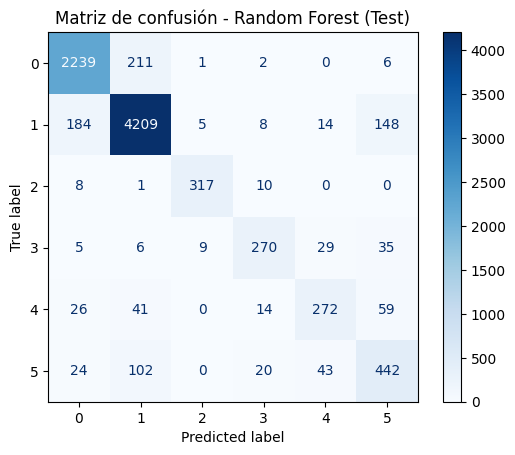

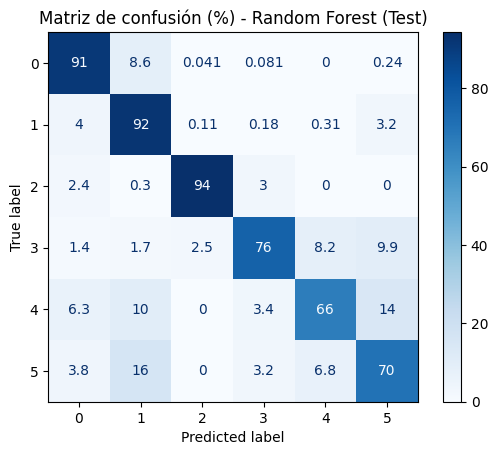

In [6]:
print(f"Mejor configuración Grich {grich_n}:", mejor_cfg, "F1-macro:", round(mejor_f1, 4))

print(f"⏱ Test: {mejor_pred_s:.3f}s  ({mejor_fit_s:.2f} ms/muestra)")
print(f"OA: {mejor_oa:.4f} | Prec(macro): {mejor_prec:.4f} | Recall(macro): {mejor_rec:.4f} | F1-macro: {mejor_f1m:.4f}")

ConfusionMatrixDisplay(mejor_cm).plot(cmap='Blues')
plt.title("Matriz de confusión - Random Forest (Test)")
plt.show()

ConfusionMatrixDisplay(mejor_cm_per).plot(cmap='Blues')
plt.title("Matriz de confusión (%) - Random Forest (Test)")
plt.show()

# Registrar informacion